In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from node2vec import Node2Vec
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import gensim.downloader as api
from gensim.models import Word2Vec
from torchvision import datasets, transforms
import torchvision.models as models
import torch
from sklearn.datasets import fetch_openml
import umap
import umap.umap_ as umap
from sklearn.preprocessing import MinMaxScaler
import os
import librosa

### Обработка текстового файла

In [27]:
dataset = api.load("text8")
data = [d for d in dataset]
data[1]

['reciprocity',
 'qualitative',
 'impairments',
 'in',
 'communication',
 'as',
 'manifested',
 'by',
 'at',
 'least',
 'one',
 'of',
 'the',
 'following',
 'delay',
 'in',
 'or',
 'total',
 'lack',
 'of',
 'the',
 'development',
 'of',
 'spoken',
 'language',
 'not',
 'accompanied',
 'by',
 'an',
 'attempt',
 'to',
 'compensate',
 'through',
 'alternative',
 'modes',
 'of',
 'communication',
 'such',
 'as',
 'gesture',
 'or',
 'mime',
 'in',
 'individuals',
 'with',
 'adequate',
 'speech',
 'marked',
 'impairment',
 'in',
 'the',
 'ability',
 'to',
 'initiate',
 'or',
 'sustain',
 'a',
 'conversation',
 'with',
 'others',
 'stereotyped',
 'and',
 'repetitive',
 'use',
 'of',
 'language',
 'or',
 'idiosyncratic',
 'language',
 'lack',
 'of',
 'varied',
 'spontaneous',
 'make',
 'believe',
 'play',
 'or',
 'social',
 'imitative',
 'play',
 'appropriate',
 'to',
 'developmental',
 'level',
 'restricted',
 'repetitive',
 'and',
 'stereotyped',
 'patterns',
 'of',
 'behavior',
 'interests'

In [3]:
model = Word2Vec(sentences=data, vector_size=100, window=5, min_count=5, workers=4)

In [4]:
embeddings = []
for item in data:
    embedding = np.mean([model.wv[word] for word in item if word in model.wv], axis=0)
    embeddings.append(embedding)

In [5]:
kmeans = KMeans(n_clusters=5)
clusters = kmeans.fit_predict(embeddings)

In [6]:
cluster_df = pd.DataFrame({"Text": data, "Cluster": clusters})
cluster_summary = cluster_df.groupby("Cluster").agg({"Text": "count"}).reset_index()
cluster_summary = cluster_summary.rename(columns={"Text": "Count"})
print(cluster_summary)

   Cluster  Count
0        0    402
1        1    556
2        2    259
3        3     63
4        4    421


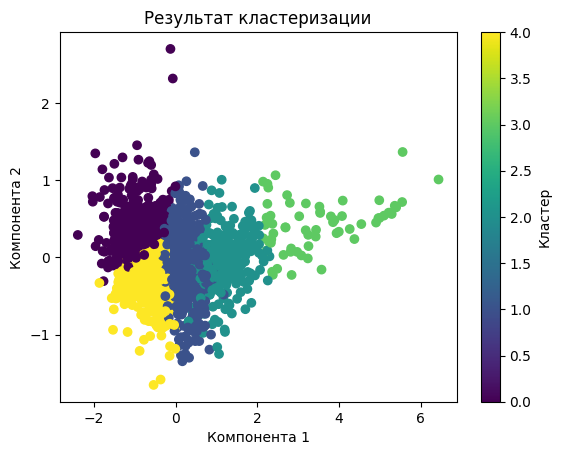

In [7]:
pca = PCA(n_components=2)
embedding_2d = pca.fit_transform(embeddings)
plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], c=clusters, cmap='viridis')
plt.title('Результат кластеризации')
plt.xlabel('Компонента 1')
plt.ylabel('Компонента 2')
plt.colorbar(label='Кластер')
plt.show()

### Обработка файлов с изображениями

In [8]:
mnist = fetch_openml('mnist_784', version=1)
X, y = mnist["data"], mnist["target"]
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [9]:
mapper = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
embedding = mapper.fit_transform(X_scaled)

/opt/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [10]:
n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(embedding)

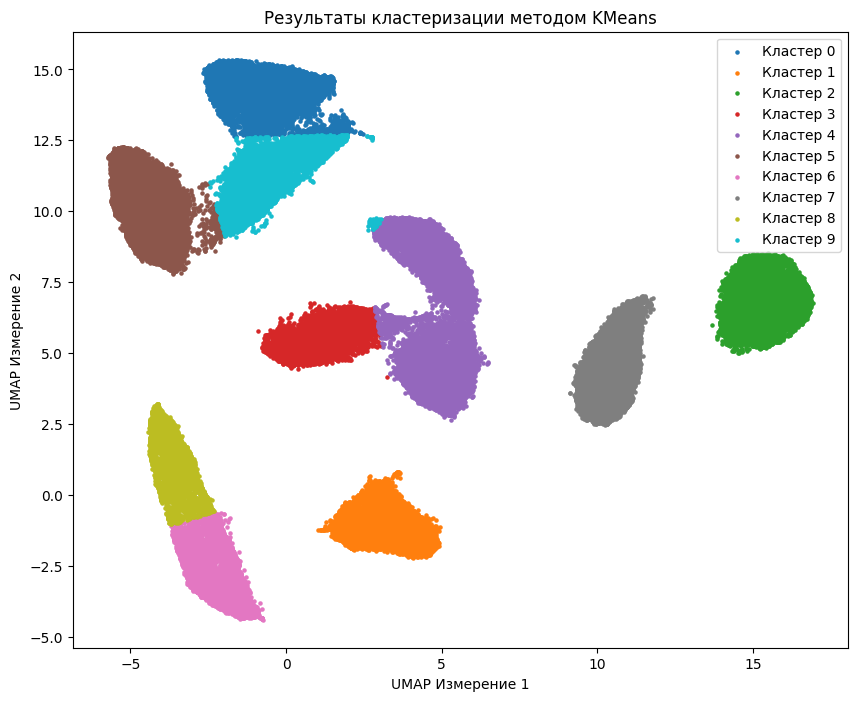

In [11]:
plt.figure(figsize=(10, 8))
for i in range(n_clusters):
    plt.scatter(embedding[cluster_labels == i, 0], 
                embedding[cluster_labels == i, 1], 
                label=f'Кластер {i}', s=5)
plt.title('Результаты кластеризации методом KMeans')
plt.xlabel('UMAP Измерение 1')
plt.ylabel('UMAP Измерение 2')
plt.legend()
plt.show()

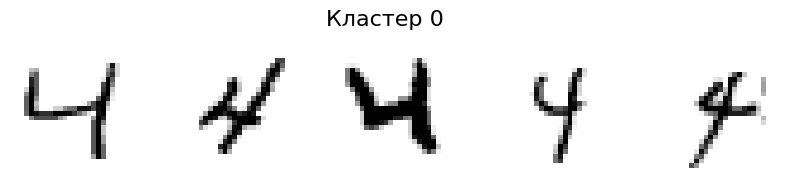

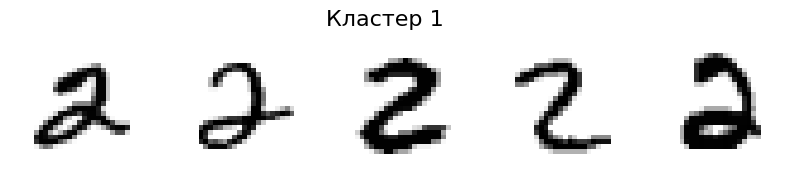

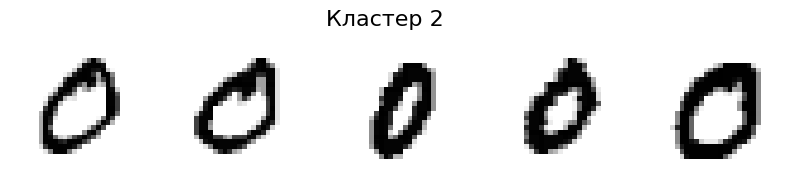

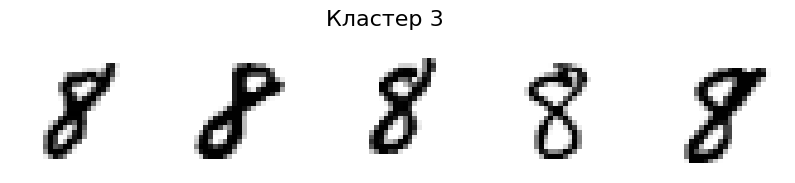

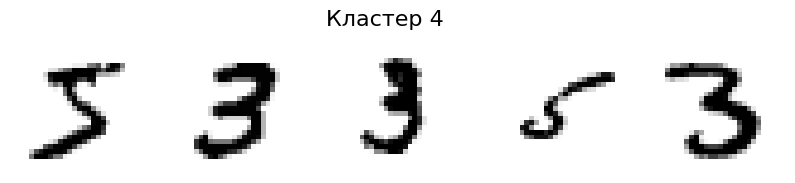

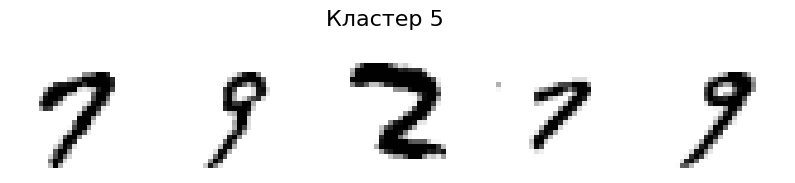

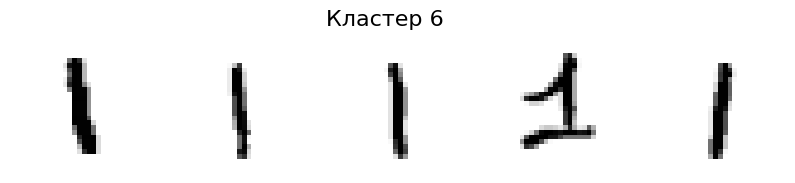

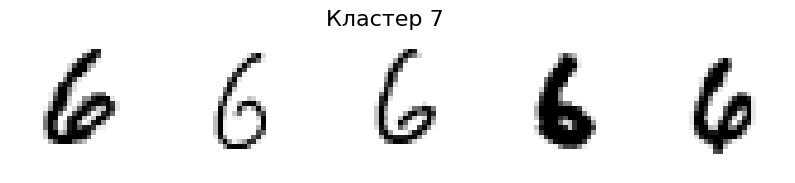

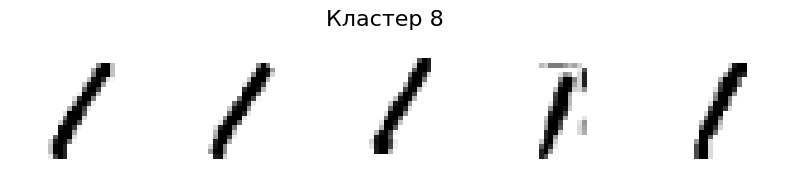

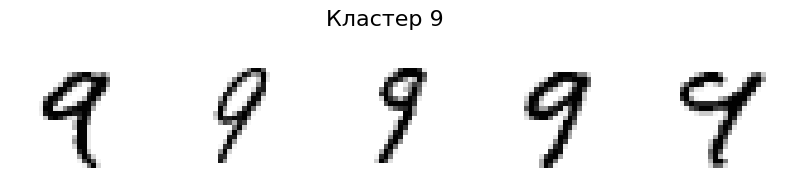

In [12]:
for cluster in range(n_clusters):
    cluster_indices = np.where(cluster_labels == cluster)[0]
    cluster_samples = X_scaled[cluster_indices[:5]]
    fig, axs = plt.subplots(1, 5, figsize=(10, 2))
    fig.suptitle(f'Кластер {cluster}', fontsize=16)
    for i, sample in enumerate(cluster_samples):
        axs[i].imshow(sample.reshape(28, 28), cmap='binary')
        axs[i].axis('off')
    plt.show()

### Обработка аудио-файлов

In [13]:
def extract_features(audio_path, sr=22050, n_mfcc=13, n_fft=2048, hop_length=512):
    y, sr = librosa.load(audio_path, sr=sr)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)
    mfccs_mean = np.mean(mfccs.T, axis=0)
    return mfccs_mean

In [14]:
audio_dir = "/Users/kaster_wid/Desktop/Studies/audio_files"

In [15]:
features = []
for file in os.listdir(audio_dir):
    if file.endswith(".mp3"):
        audio_path = os.path.join(audio_dir, file)
        audio_features = extract_features(audio_path)
        features.append(audio_features)
features = np.array(features)

In [16]:
mapper = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
embedding_umap = mapper.fit_transform(features)

/opt/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/opt/anaconda3/lib/python3.11/site-packages/umap/umap_.py:2437: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


In [17]:
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(embedding_umap)

In [18]:
for cluster in range(n_clusters):
    cluster_indices = np.where(cluster_labels == cluster)[0]
    print(f"Кластер {cluster}: {len(cluster_indices)} аудиофайлов")

Кластер 0: 3 аудиофайлов
Кластер 1: 6 аудиофайлов
Кластер 2: 2 аудиофайлов


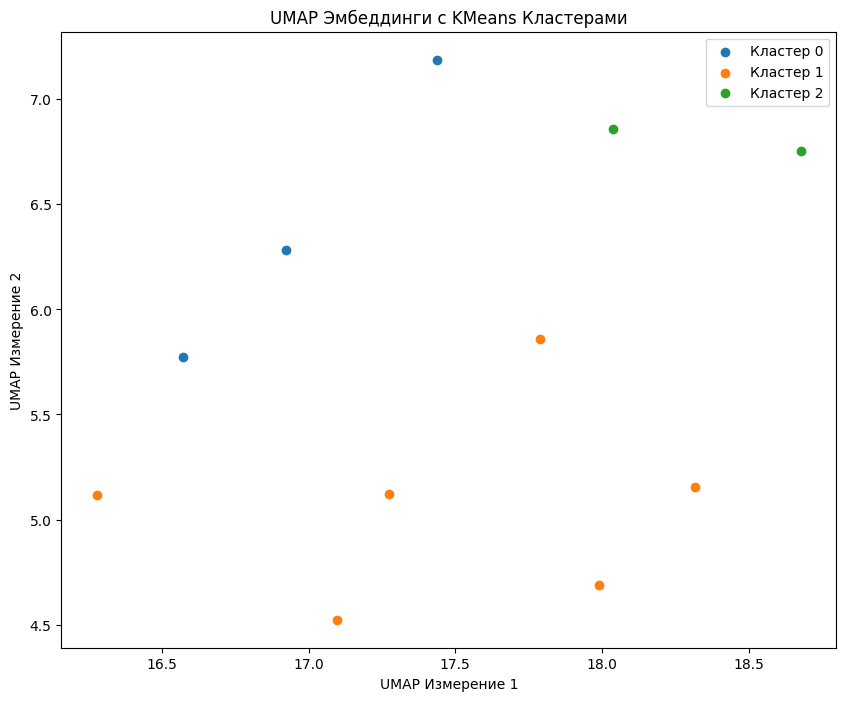

In [19]:
plt.figure(figsize=(10, 8))
for cluster in range(n_clusters):
    cluster_samples = embedding_umap[cluster_labels == cluster]
    plt.scatter(cluster_samples[:, 0], cluster_samples[:, 1], label=f'Кластер {cluster}')
plt.title('UMAP Эмбеддинги с KMeans Кластерами')
plt.xlabel('UMAP Измерение 1')
plt.ylabel('UMAP Измерение 2')
plt.legend()
plt.show()

### Обработка графов

In [20]:
G = nx.fast_gnp_random_graph(100, 0.05)

In [21]:
def get_node_embeddings(graph):
    node2vec = Node2Vec(graph, dimensions=64, walk_length=30, num_walks=200, workers=4)
    model = node2vec.fit(window=10, min_count=1, batch_words=4)
    node_embeddings = [model.wv[str(node)] for node in range(len(graph.nodes))]
    return np.array(node_embeddings)

In [22]:
kmeans = KMeans(n_clusters=5)
clusters = kmeans.fit_predict(embeddings)

In [23]:
cluster_dict = {}
for node, cluster in enumerate(clusters):
    if cluster not in cluster_dict:
        cluster_dict[cluster] = [node]
    else:
        cluster_dict[cluster].append(node)
for cluster, nodes in cluster_dict.items():
    print(f"Кластер {cluster}: {len(nodes)} узлов")

Кластер 0: 556 узлов
Кластер 2: 727 узлов
Кластер 1: 157 узлов
Кластер 4: 218 узлов
Кластер 3: 43 узлов


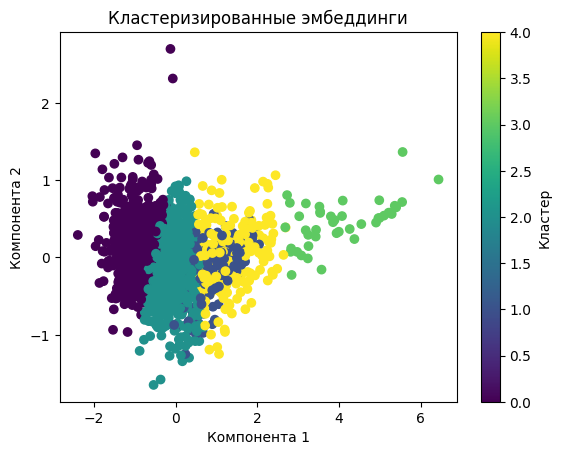

In [24]:
pca = PCA(n_components=2)
embedding_2d = pca.fit_transform(embeddings)
plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], c=clusters, cmap='viridis')
plt.title('Кластеризированные эмбеддинги')
plt.xlabel('Компонента 1')
plt.ylabel('Компонента 2')
plt.colorbar(label='Кластер')
plt.show()